# TrainSelPy: Comprehensive Guide

This notebook is a comprehensive guide to TrainSelPy, demonstrating all of its key features and applications. TrainSelPy is a Python package for optimizing selection problems, particularly in the context of training population design for genomic prediction and breeding programs.

## Table of Contents

1. [Introduction](#Introduction)
2. [Installation](#Installation)
3. [Basic Concepts](#Basic-Concepts)
4. [Unordered Subset Selection](#Unordered-Subset-Selection)
5. [Ordered Subset Selection](#Ordered-Subset-Selection)
6. [Combinatorial Optimization](#Combinatorial-Optimization)
7. [Single-Objective Optimization with Multiple Criteria](#Single-Objective-Optimization-with-Multiple-Criteria)
8. [Genomic Selection Applications](#Genomic-Selection-Applications)
9. [Advanced Features](#Advanced-Features)
10. [Custom Optimization Functions](#Custom-Optimization-Functions)
11. [Performance Optimization](#Performance-Optimization)
12. [Real-world Applications](#Real-world-Applications)

## Introduction

TrainSelPy is a Python implementation of the TrainSel algorithm, designed for optimizing selection problems in various domains. It's particularly valuable for:

- Selecting optimal training populations for genomic prediction
- Solving combinatorial optimization problems
- Optimizing selection problems with competing objectives
- Handling ordered and unordered selection problems

This vignette will guide you through the various features and applications of TrainSelPy, providing examples and explaining the underlying concepts.

## Installation

TrainSelPy can be installed directly from the GitHub repository or using pip if it's available on PyPI.

In [1]:
# Install TrainSelPy from GitHub (if not already installed)
# !pip install git+https://github.com/dakdemirGithub/TrainSelPublic_StartingPoint.git#subdirectory=trainselpy

# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

# Import TrainSelPy components
from trainselpy import (
    make_data,
    train_sel,
    train_sel_control,
    set_control_default,
    dopt,
    cdmean_opt,
    maximin_opt,
    pev_opt,
    time_estimation
)

# For visualization
%matplotlib inline
plt.style.use('ggplot')

## Basic Concepts

Before diving into examples, let's understand the core concepts of TrainSelPy:

### Selection Types

TrainSelPy supports multiple types of selection problems:

1. **Unordered Set (UOS)**: Selection where order doesn't matter (e.g., selecting committee members)
2. **Ordered Set (OS)**: Selection where order matters (e.g., sequential sampling)
3. **Unordered Multiset (UOMS)**: Selection where order doesn't matter but repetition is allowed
4. **Ordered Multiset (OMS)**: Selection where both order and repetition matter
5. **Boolean (BOOL)**: Selection of binary variables (0/1)
6. **Double (DBL)**: Selection of continuous variables (0-1)

### Optimization Criteria

TrainSelPy includes several built-in optimization criteria:

1. **D-optimality**: Maximizing determinant of information matrix
2. **CDMean**: Coefficient of Determination mean (for genomic prediction)
3. **PEV**: Prediction Error Variance minimization
4. **Maximin**: Maximizing minimum distance between selected samples

### Optimization Algorithm

TrainSelPy uses genetic algorithms for optimization, with features like:

1. **Island Model**: Parallel populations evolving independently with migration
2. **Simulated Annealing**: Fine-tuning solutions at the end of optimization
3. **Custom Objective Functions**: Flexibility to define your own criteria

## Unordered Subset Selection

The most common use case for TrainSelPy is unordered subset selection - selecting a subset of items from a larger set where the order doesn't matter.

Let's start with a simple example:

In [2]:
# Create a small test dataset
n_samples = 100
n_features = 20

np.random.seed(42)  # For reproducibility

# Create a marker matrix (simulated genotypes)
M = np.random.choice([-1, 0, 1], size=(n_samples, n_features), p=[0.25, 0.5, 0.25])

# Create a relationship matrix (genomic relationships)
K = np.dot(M, M.T) / n_features

# Add a small value to the diagonal to ensure positive definiteness
K += np.eye(n_samples) * 1e-6

print(f"Created dataset with {n_samples} samples and {n_features} features")

# Create the TrainSel data object
ts_data = make_data(M=M)

# For D-optimality, we need to add the feature matrix to the data
ts_data["FeatureMat"] = M

# Set control parameters (limited iterations for example)
control = set_control_default()
control["niterations"] = 30  # Reduced for demonstration
control["npop"] = 100

# Run the selection algorithm with D-optimality
result = train_sel(
    data=ts_data,
    candidates=[list(range(n_samples))],  # Select from all samples
    setsizes=[10],                      # Select 10 samples
    settypes=["UOS"],                  # Unordered set
    stat=dopt,                         # Use D-optimality
    control=control,
    verbose=True
)

print(f"\nSelected {len(result.selected_indices[0])} samples:")
print(f"Selected indices: {result.selected_indices[0]}")
print(f"Final fitness (D-optimality): {result.fitness:.6f}")

Created dataset with 100 samples and 20 features
Starting TrainSelPy optimization
Starting GA with population size 100
Initial best fitness: -207.91094921929118
Generation 0: Best fitness = -207.54613398206462
Generation 10: Best fitness = -206.28233926878806
Generation 20: Best fitness = -206.09317926563867
Optimization completed in 0.53 seconds
Final fitness: -205.96217752145142

Selected 10 samples:
Selected indices: [2, 5, 21, 33, 44, 54, 55, 70, 71, 87]
Final fitness (D-optimality): -205.962178


### Visualizing the Selection

Let's visualize our selection using PCA to reduce dimensions:

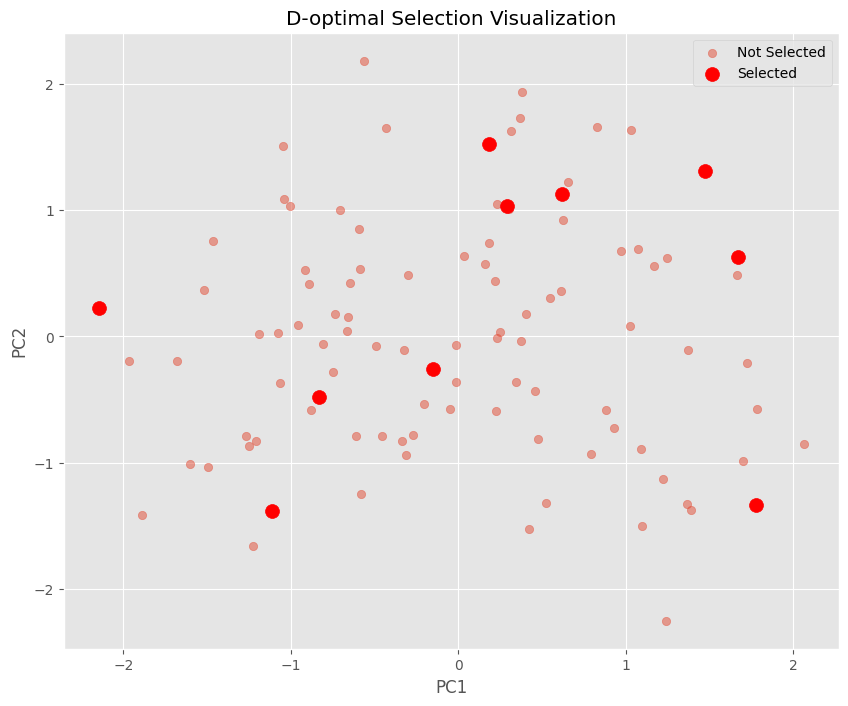

In [3]:
from sklearn.decomposition import PCA

# Use PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
M_reduced = pca.fit_transform(M)

# Create a mask for selected samples
selected_mask = np.zeros(n_samples, dtype=bool)
selected_mask[result.selected_indices[0]] = True

# Plot the samples in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(M_reduced[~selected_mask, 0], M_reduced[~selected_mask, 1], alpha=0.5, label="Not Selected")
plt.scatter(M_reduced[selected_mask, 0], M_reduced[selected_mask, 1], color="red", s=100, label="Selected")
plt.title("D-optimal Selection Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

## Ordered Subset Selection

Let's now look at ordered subset selection ("OS"), which is useful for problems like the traveling salesman problem or sequential sampling.

In [4]:
# Generate a random distance matrix for a TSP-like problem
n_cities = 20  # Reduced for faster execution
np.random.seed(42)
city_coords = np.random.rand(n_cities, 2) * 100  # Random coordinates in 2D space

# Calculate distances between cities
dist_matrix = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(n_cities):
        dist_matrix[i, j] = np.sqrt(np.sum((city_coords[i] - city_coords[j])**2))

# Convert to a form that TrainSelPy can use
dist_df = pd.DataFrame(dist_matrix)

# Create a data object for TrainSelPy
ts_data = {"DistMat": dist_df}

# Define a TSP fitness function (minimize total distance)
def tsp_fitness(solution, data):
    """Calculate the negative total tour distance."""
    dist_mat = data["DistMat"]
    total_dist = 0
    
    # Calculate total tour distance including return to start
    for i in range(len(solution)):
        from_city = solution[i]
        to_city = solution[(i + 1) % len(solution)]
        total_dist += dist_mat.iloc[from_city, to_city]
    
    # Return negative distance (as TrainSelPy maximizes by default)
    return -total_dist

# Set control parameters
control = set_control_default()
control["niterations"] = 50
control["npop"] = 200
control["nelite"] = 50
control["mutprob"] = 0.1
control["crossprob"] = 0.8

# Run the TSP optimization
start_time = time.time()
result_tsp = train_sel(
    data=ts_data,
    candidates=[list(range(n_cities))],
    setsizes=[n_cities],  # Select all cities (full tour)
    settypes=["OS"],      # Ordered set (the order matters)
    stat=tsp_fitness,
    control=control,
    verbose=True
)
runtime = time.time() - start_time

print(f"\nTSP optimization completed in {runtime:.2f} seconds")
print(f"Tour length: {-result_tsp.fitness:.2f} units")
print(f"Tour: {result_tsp.selected_indices[0]}")

Starting TrainSelPy optimization
Starting GA with population size 200
Initial best fitness: -798.264744534833
Generation 0: Best fitness = -657.4866818655776
Generation 10: Best fitness = -593.3412850667844
Generation 20: Best fitness = -471.98152784650495
Generation 30: Best fitness = -406.9608974852434
Generation 40: Best fitness = -399.95013977948406
Optimization completed in 4.01 seconds
Final fitness: -388.1977580412989

TSP optimization completed in 4.01 seconds
Tour length: 388.20 units
Tour: [10, 14, 6, 19, 1, 17, 4, 12, 0, 5, 16, 3, 13, 8, 11, 7, 2, 18, 9, 15]


### Visualizing the TSP Tour

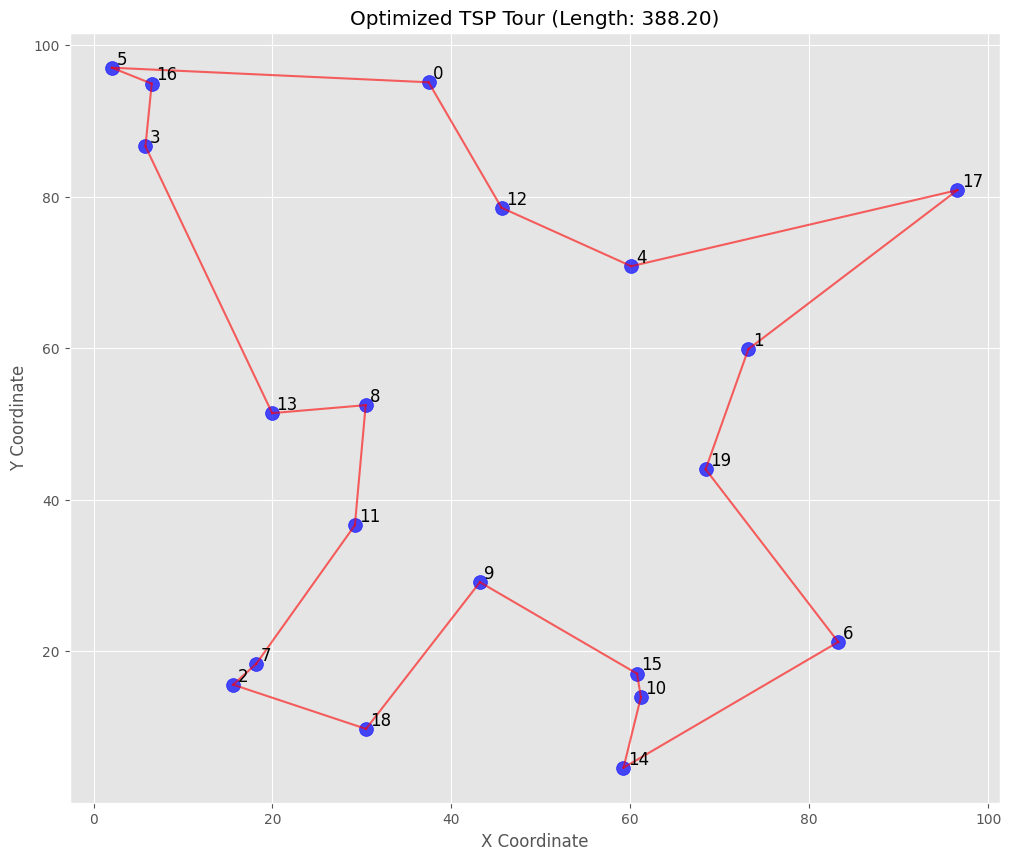

In [5]:
# Get the optimized tour
tour = result_tsp.selected_indices[0]

# Plot the tour
plt.figure(figsize=(12, 10))
plt.scatter(city_coords[:, 0], city_coords[:, 1], s=100, c='blue', alpha=0.7)

# Add city labels
for i in range(n_cities):
    plt.text(city_coords[i, 0] + 0.5, city_coords[i, 1] + 0.5, str(i), fontsize=12)

# Plot the tour path
for i in range(len(tour)):
    from_city = tour[i]
    to_city = tour[(i + 1) % len(tour)]
    plt.plot([city_coords[from_city, 0], city_coords[to_city, 0]],
             [city_coords[from_city, 1], city_coords[to_city, 1]], 'r-', alpha=0.6)

plt.title(f"Optimized TSP Tour (Length: {-result_tsp.fitness:.2f})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

## Combinatorial Optimization

TrainSelPy can handle various combinatorial optimization problems, including mixed integer problems where you have both discrete and continuous variables.

Let's create a simple mixed integer problem:

In [6]:
# Define a mixed integer problem
# - Select 5 items from a set of 20
# - Assign continuous weights (0-1) to each selected item
# - Maximize a weighted sum function

n_items = 20
n_select = 5
n_weights = n_select

# Create random item values
np.random.seed(123)
item_values = np.random.rand(n_items) * 10
item_costs = np.random.rand(n_items) * 5

# Create data object
mixed_data = {
    "values": item_values,
    "costs": item_costs,
    "budget": 10.0  # Maximum total cost
}

# Define mixed integer fitness function
def mixed_integer_fitness(int_solution, dbl_solution, data):
    """Fitness function for mixed integer problem."""
    selected_items = int_solution
    weights = dbl_solution
    
    # Normalize weights to sum to 1
    weights = np.array(weights) / np.sum(weights)
    
    # Calculate total value and cost
    total_value = np.sum(data["values"][selected_items] * weights)
    total_cost = np.sum(data["costs"][selected_items] * weights)
    
    # Apply penalty if over budget
    if total_cost > data["budget"]:
        penalty = (total_cost - data["budget"]) * 20
        return total_value - penalty
    
    return total_value

# Set control parameters
control = set_control_default()
control["niterations"] = 30
control["npop"] = 100

# Run the mixed integer optimization
result_mixed = train_sel(
    data=mixed_data,
    candidates=[
        list(range(n_items)),  # Integer candidates
        list(range(n_weights))  # Just placeholder for continuous vars
    ],
    setsizes=[n_select, n_weights],
    settypes=["UOS", "DBL"],  # UOS for items, DBL for weights
    stat=mixed_integer_fitness,
    control=control,
    verbose=True
)

# Get results
selected_items = result_mixed.selected_indices[0]
selected_weights_raw = result_mixed.selected_values[0]
selected_weights = np.array(selected_weights_raw) / np.sum(selected_weights_raw)

# Calculate final metrics
total_value = np.sum(item_values[selected_items] * selected_weights)
total_cost = np.sum(item_costs[selected_items] * selected_weights)

print(f"\nSelected items: {selected_items}")
print(f"Normalized weights: {selected_weights}")
print(f"Total value: {total_value:.2f}")
print(f"Total cost: {total_cost:.2f} (Budget: {mixed_data['budget']})")

Starting TrainSelPy optimization
Starting GA with population size 100
Initial best fitness: 7.506402224201283
Initialized CMA-ES for continuous variables (sigma=0.2)
Generation 0: Best fitness = 8.403956435572741
Generation 10: Best fitness = 8.885267474232297
Generation 20: Best fitness = 9.807641983846155
Optimization completed in 0.37 seconds
Final fitness: 9.807641983846155

Selected items: [0, 3, 4, 6, 7]
Normalized weights: [0. 0. 0. 1. 0.]
Total value: 9.81
Total cost: 1.81 (Budget: 10.0)


### Visualize the Mixed Integer Solution

All Items:


,Item,Value,Cost,Value/Cost,Selected
0,0,6.964692,3.172005,2.195675,Yes
1,1,2.861393,4.247159,0.673719,No
2,2,2.268515,3.622277,0.626268,No
3,3,5.513148,3.055118,1.804562,Yes
4,4,7.194690,3.612217,1.991766,Yes
5,5,4.231065,1.614795,2.620188,No
6,6,9.807642,1.808943,5.421752,Yes
7,7,6.848297,1.141316,6.000351,Yes
8,8,4.809319,1.468570,3.274831,No
9,9,3.921175,3.154881,1.242892,No



Selected Items:


,Item,Value,Cost,Weight,Weighted Value,Weighted Cost
0,0,6.964692,3.172005,0.0,0.000000,0.000000
1,3,5.513148,3.055118,0.0,0.000000,0.000000
2,4,7.194690,3.612217,0.0,0.000000,0.000000
3,6,9.807642,1.808943,1.0,9.807642,1.808943
4,7,6.848297,1.141316,0.0,0.000000,0.000000


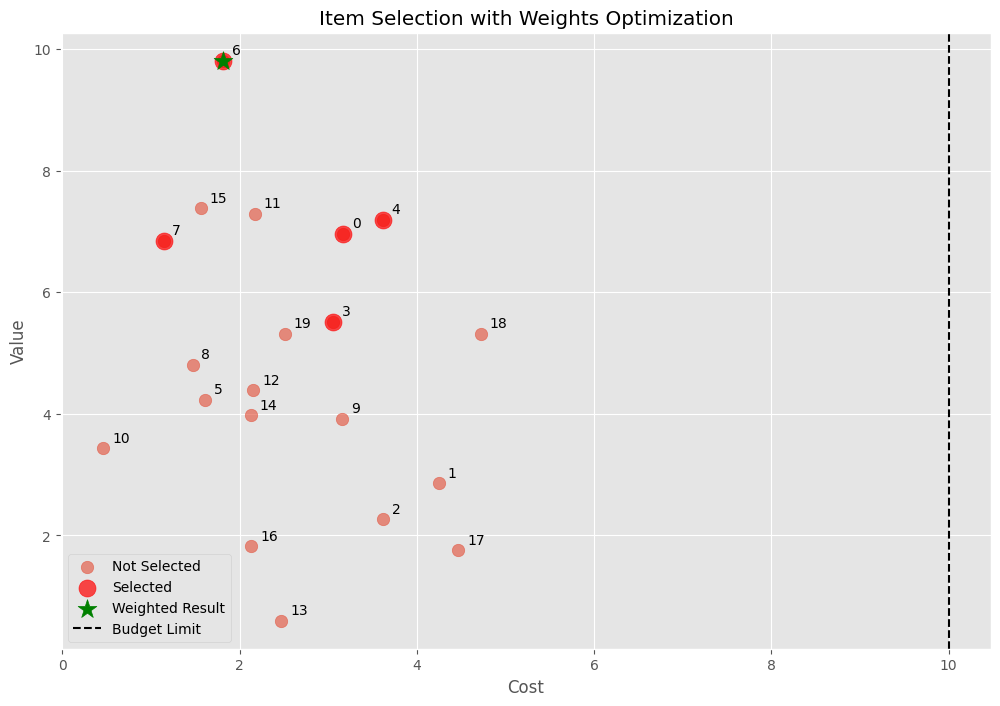

In [7]:
# Create a dataframe with all items
all_items_df = pd.DataFrame({
    'Item': range(n_items),
    'Value': item_values,
    'Cost': item_costs,
    'Value/Cost': item_values / item_costs,
    'Selected': ['Yes' if i in selected_items else 'No' for i in range(n_items)]
})

# Create a dataframe with just the selected items and their weights
selected_df = pd.DataFrame({
    'Item': selected_items,
    'Value': item_values[selected_items],
    'Cost': item_costs[selected_items],
    'Weight': selected_weights,
    'Weighted Value': item_values[selected_items] * selected_weights,
    'Weighted Cost': item_costs[selected_items] * selected_weights
})

# Display the dataframes
print("All Items:")
display(all_items_df)

print("\nSelected Items:")
display(selected_df)

# Visualize the value-cost tradeoff
plt.figure(figsize=(12, 8))
plt.scatter(item_costs, item_values, s=80, alpha=0.6, label="Not Selected")
plt.scatter(item_costs[selected_items], item_values[selected_items], s=150, c='red', alpha=0.7, label="Selected")

# Add item labels
for i in range(n_items):
    plt.text(item_costs[i] + 0.1, item_values[i] + 0.1, str(i), fontsize=10)

# Add weighted positions
weighted_cost = np.sum(item_costs[selected_items] * selected_weights)
weighted_value = np.sum(item_values[selected_items] * selected_weights)
plt.scatter([weighted_cost], [weighted_value], s=200, c='green', marker='*', label="Weighted Result")

plt.axvline(x=mixed_data['budget'], color='black', linestyle='--', label="Budget Limit")

plt.title("Item Selection with Weights Optimization")
plt.xlabel("Cost")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## Single-Objective Optimization with Multiple Criteria

TrainSelPy can combine multiple criteria into a single objective function. This approach is useful when you want to balance multiple criteria without going into full multi-objective optimization.

In [8]:
# Create a simulated breeding population dataset
n_individuals = 100
n_markers = 50

np.random.seed(123)
# Simulate marker data
M = np.random.choice([-1, 0, 1], size=(n_individuals, n_markers), p=[0.25, 0.5, 0.25])

# Create a relationship matrix (genomic relationships)
K = np.dot(M, M.T) / n_markers

# Add small diagonal value for numerical stability
K += np.eye(n_individuals) * 1e-6

# Simulate breeding values
breeding_values = np.random.normal(0, 1, size=n_individuals)
breeding_values = breeding_values * 10 + 100  # Scale for better visualization

# Create data object
breeding_data = {
    "breeding_values": breeding_values,
    "K": K
}

# Define a function that balances genetic gain and diversity
def balanced_selection(solution, data):
    """Objective function balancing genetic gain and diversity."""
    breeding_values = data["breeding_values"]
    K = data["K"]
    
    # Calculate genetic gain (mean breeding value of selected individuals)
    genetic_gain = np.mean(breeding_values[solution])
    
    # Calculate inbreeding (mean relationship coefficient among selected)
    selected_K = K[np.ix_(solution, solution)]
    # Get off-diagonal elements (relationships between different individuals)
    mask = ~np.eye(selected_K.shape[0], dtype=bool)
    inbreeding = np.mean(selected_K[mask])
    
    # Balance the two objectives (maximize gain, minimize inbreeding)
    # Scale genetic gain to be roughly in the same range as inbreeding
    scaled_gain = (genetic_gain - 90) / 20  # Assuming breeding values around 100
    
    # Weighted combination
    return 0.7 * scaled_gain - 0.3 * inbreeding

# Set control parameters
control = set_control_default()
control["niterations"] = 30
control["npop"] = 150

# Run the optimization
result_balanced = train_sel(
    data=breeding_data,
    candidates=[list(range(n_individuals))],
    setsizes=[10],  # Select 10 individuals
    settypes=["UOS"],
    stat=balanced_selection,
    control=control,
    verbose=True
)

# Print the selected individuals
selected = result_balanced.selected_indices[0]
print(f"\nSelected individuals: {selected}")
print(f"Fitness: {result_balanced.fitness:.4f}")

# Calculate the individual components
genetic_gain = np.mean(breeding_values[selected])
selected_K = K[np.ix_(selected, selected)]
mask = ~np.eye(selected_K.shape[0], dtype=bool)
inbreeding = np.mean(selected_K[mask])

print(f"Genetic gain: {genetic_gain:.4f}")
print(f"Average inbreeding: {inbreeding:.4f}")

Starting TrainSelPy optimization
Starting GA with population size 150
Initial best fitness: 0.669047450819404
Generation 0: Best fitness = 0.7433565502534383
Generation 10: Best fitness = 0.9495497410885275
Generation 20: Best fitness = 1.0192106042494744
Optimization completed in 0.44 seconds
Final fitness: 1.02618815127302

Selected individuals: [4, 15, 21, 36, 45, 49, 54, 65, 71, 86]
Fitness: 1.0262
Genetic gain: 119.3311
Average inbreeding: 0.0013


### Compare with Random Selections

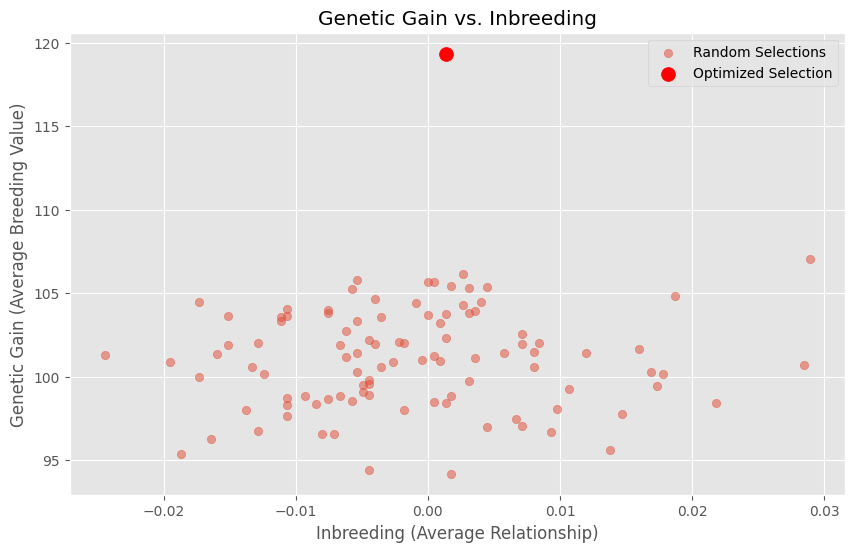

In [9]:
# Compare with random selections
n_random = 100
random_gains = []
random_inbreedings = []

for _ in range(n_random):
    random_selection = np.random.choice(n_individuals, size=10, replace=False)
    
    # Calculate gain
    gain = np.mean(breeding_values[random_selection])
    random_gains.append(gain)
    
    # Calculate inbreeding
    sel_K = K[np.ix_(random_selection, random_selection)]
    mask = ~np.eye(sel_K.shape[0], dtype=bool)
    inb = np.mean(sel_K[mask])
    random_inbreedings.append(inb)

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.scatter(random_inbreedings, random_gains, alpha=0.5, label="Random Selections")
plt.scatter([inbreeding], [genetic_gain], color='red', s=100, label="Optimized Selection")

plt.title("Genetic Gain vs. Inbreeding")
plt.xlabel("Inbreeding (Average Relationship)")
plt.ylabel("Genetic Gain (Average Breeding Value)")
plt.legend()
plt.grid(True)
plt.show()

### Breeding Example with Mixed Variable Types

In breeding applications, we often need to select individuals and assign mating proportions. This is a mixed type problem with both integer variables (which individuals to select) and continuous variables (mating proportions).

In [10]:
# Define a multi-objective function for optimal contribution selection
def optimal_contributions(int_sol, dbl_sol, data):
    """Calculate a combined objective for gain and inbreeding with contribution proportions."""
    # Normalize the contributions (proportions)
    props = np.array(dbl_sol) / np.sum(dbl_sol)
    
    breeding_values = data["breeding_values"]
    K = data["K"]
    
    # Weighted genetic gain
    genetic_gain = np.sum(breeding_values[int_sol] * props)
    
    # Expected inbreeding (quadratic form: p'Kp)
    selected_K = K[np.ix_(int_sol, int_sol)]
    inbreeding = props.T @ selected_K @ props
    
    # Combine objectives (with appropriate scaling)
    scaled_gain = (genetic_gain - 90) / 20
    return 0.7 * scaled_gain - 0.3 * inbreeding

# Optimize both selection and contributions
result_ocs = train_sel(
    data=breeding_data,
    candidates=[
        list(range(n_individuals)),  # Integer candidates
        list(range(5))               # Just placeholder for 5 continuous variables
    ],
    setsizes=[5, 5],                 # Select 5 individuals with 5 contribution values
    settypes=["UOS", "DBL"],         # UOS for individuals, DBL for contributions
    stat=optimal_contributions,
    control=control,
    verbose=True
)

# Print results
selected_inds = result_ocs.selected_indices[0]
contribution_raw = result_ocs.selected_values[0]
contributions = np.array(contribution_raw) / np.sum(contribution_raw)

print(f"\nSelected individuals: {selected_inds}")
print(f"Contributions: {contributions}")

# Calculate final metrics
genetic_gain = np.sum(breeding_values[selected_inds] * contributions)
selected_K = K[np.ix_(selected_inds, selected_inds)]
inbreeding = contributions.T @ selected_K @ contributions

print(f"Genetic gain: {genetic_gain:.4f}")
print(f"Expected inbreeding: {inbreeding:.4f}")

Starting TrainSelPy optimization
Starting GA with population size 150
Initial best fitness: 0.7478612954064504
Initialized CMA-ES for continuous variables (sigma=0.2)
Generation 0: Best fitness = 0.8990968615247126
Generation 10: Best fitness = 1.1132389767287691
Generation 20: Best fitness = 1.1443970323829682
Optimization completed in 0.48 seconds
Final fitness: 1.1443970323829682

Selected individuals: [4, 42, 54, 65, 90]
Contributions: [0.47876037 0.         0.10252319 0.41871644 0.        ]
Genetic gain: 123.9018
Expected inbreeding: 0.1406


## Genomic Selection Applications

Let's explore how TrainSelPy can be used for genomic selection, particularly for training population optimization. We'll simulate a breeding population and use TrainSelPy to optimize the training set for genomic prediction.

In [11]:
from sklearn.linear_model import Ridge

# Function to simulate breeding data with genetic values and phenotypes
def simulate_breeding_data(n_individuals=200, n_markers=300, h2=0.5):
    """Simulate a breeding population with markers and phenotypes."""
    # Simulate marker matrix
    M = np.random.choice([-1, 0, 1], size=(n_individuals, n_markers), p=[0.25, 0.5, 0.25])
    
    # Simulate QTL effects
    qtl_effects = np.zeros(n_markers)
    # 10% of markers are QTLs
    qtl_indices = np.random.choice(n_markers, size=int(n_markers * 0.1), replace=False)
    qtl_effects[qtl_indices] = np.random.normal(0, 1, size=len(qtl_indices))
    
    # Calculate genetic values
    genetic_values = np.dot(M, qtl_effects)
    
    # Add environmental noise based on heritability
    genetic_var = np.var(genetic_values)
    error_var = genetic_var * (1 - h2) / h2
    env_effects = np.random.normal(0, np.sqrt(error_var), size=n_individuals)
    
    # Calculate phenotypes
    phenotypes = genetic_values + env_effects
    
    # Calculate genomic relationship matrix
    K = np.dot(M, M.T) / n_markers
    K += np.eye(n_individuals) * 1e-6  # Add small diagonal for numerical stability
    
    return {
        'M': M,
        'K': K,
        'genetic_values': genetic_values,
        'phenotypes': phenotypes,
        'qtl_effects': qtl_effects
    }

# Simulate breeding data
np.random.seed(123)
sim_data = simulate_breeding_data(n_individuals=200, n_markers=300, h2=0.5)

# Split into training candidates and test set
all_indices = np.arange(200)
candidate_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

print(f"Training candidates: {len(candidate_indices)}")
print(f"Test set: {len(test_indices)}")

Training candidates: 160
Test set: 40


### Define Optimization Function for Genomic Selection

In [12]:
# Define a fitness function for prediction accuracy
def prediction_accuracy(training_indices, data):
    """Evaluate prediction accuracy with a given training set."""
    # Extract data
    M = data["M"]
    phenotypes = data["phenotypes"]
    true_genetic_values = data["genetic_values"]
    test_indices = data["test_indices"]
    
    # Prepare training and test sets
    X_train = M[training_indices, :]
    y_train = phenotypes[training_indices]
    X_test = M[test_indices, :]
    y_test_true = true_genetic_values[test_indices]
    
    # Train a Ridge regression model (commonly used in genomic prediction)
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    # Predict genetic values for the test set
    y_test_pred = model.predict(X_test)
    
    # Calculate prediction accuracy as correlation
    accuracy = np.corrcoef(y_test_true, y_test_pred)[0, 1]
    
    return accuracy

# Prepare data for TrainSelPy
gs_data = {
    "M": sim_data["M"],
    "phenotypes": sim_data["phenotypes"],
    "genetic_values": sim_data["genetic_values"],
    "test_indices": test_indices
}

# Set control parameters
control = set_control_default()
control["niterations"] = 30
control["npop"] = 150

### Optimize Training Population Size

In [13]:
# Try different training set sizes, but fewer for speed
training_sizes = [20, 40, 60]
random_accuracies = []
optimized_accuracies = []

for size in training_sizes:
    print(f"\nTraining set size: {size}")
    
    # Random selection (average of 3 repeats)
    print("  Random selection:")
    random_accuracy_sum = 0
    n_repeats = 3  # Reduced for speed
    
    for i in range(n_repeats):
        random_indices = np.random.choice(candidate_indices, size=size, replace=False)
        accuracy = prediction_accuracy(random_indices, gs_data)
        random_accuracy_sum += accuracy
        print(f"    Repeat {i+1}: Accuracy = {accuracy:.4f}")
    
    avg_random_accuracy = random_accuracy_sum / n_repeats
    random_accuracies.append(avg_random_accuracy)
    print(f"  Average random selection accuracy: {avg_random_accuracy:.4f}")
    
    # Optimized selection
    print("  Optimized selection:")
    result = train_sel(
        data=gs_data,
        candidates=[candidate_indices.tolist()],
        setsizes=[size],
        settypes=["UOS"],
        stat=prediction_accuracy,
        control=control,
        verbose=True
    )
    
    optimized_accuracy = result.fitness
    optimized_accuracies.append(optimized_accuracy)
    print(f"  Optimized selection accuracy: {optimized_accuracy:.4f}")
    print(f"  Improvement: {(optimized_accuracy - avg_random_accuracy) / avg_random_accuracy * 100:.2f}%")


Training set size: 20
  Random selection:
    Repeat 1: Accuracy = 0.4498
    Repeat 2: Accuracy = -0.0091
    Repeat 3: Accuracy = 0.1266
  Average random selection accuracy: 0.1891
  Optimized selection:
Starting TrainSelPy optimization
Starting GA with population size 150
Initial best fitness: 0.6397142353723858
Generation 0: Best fitness = 0.6397142353723858
Generation 10: Best fitness = 0.7986514208331654
Generation 20: Best fitness = 0.8623608985939056
Optimization completed in 5.56 seconds
Final fitness: 0.869217471280174
  Optimized selection accuracy: 0.8692
  Improvement: 359.62%

Training set size: 40
  Random selection:
    Repeat 1: Accuracy = 0.2710
    Repeat 2: Accuracy = 0.1749
    Repeat 3: Accuracy = 0.5452
  Average random selection accuracy: 0.3304
  Optimized selection:
Starting TrainSelPy optimization
Starting GA with population size 150
Initial best fitness: 0.6122030770753253
Generation 0: Best fitness = 0.6451567007528594
Generation 10: Best fitness = 0.82912

### Visualize Genomic Selection Results

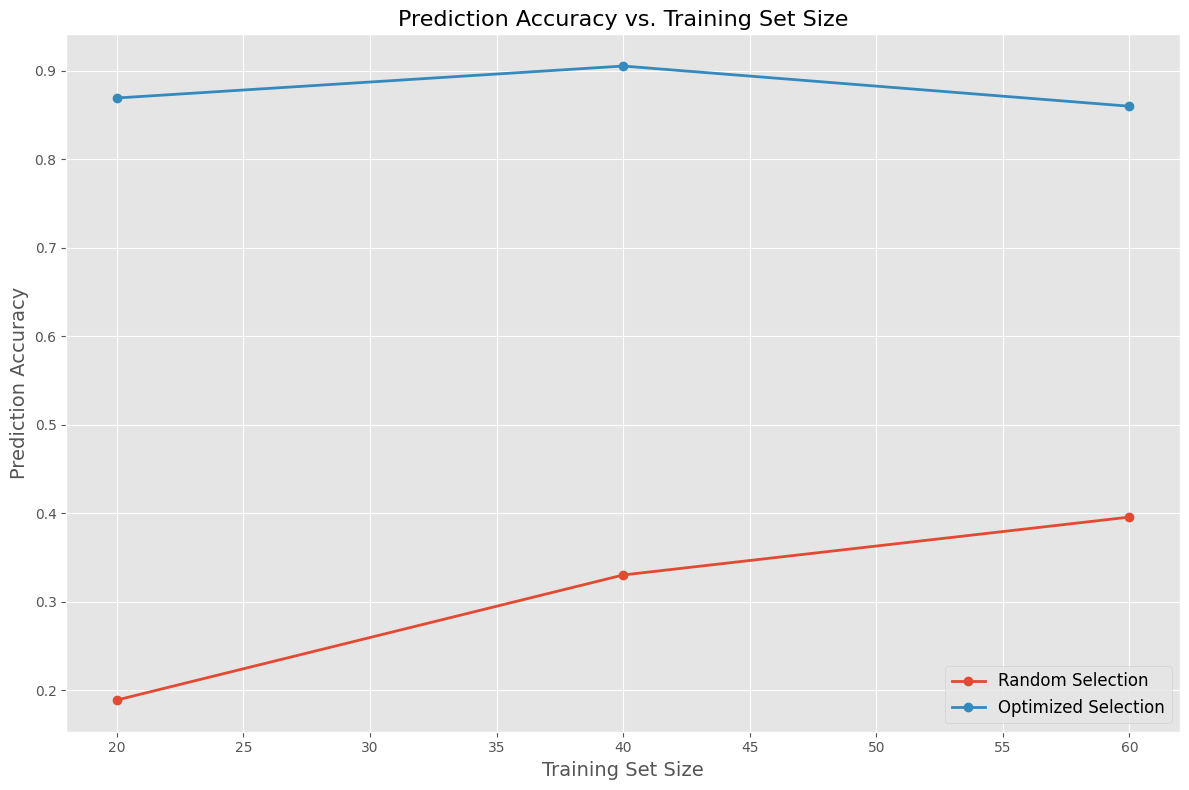

,Training Size,Random Selection,Optimized Selection,Improvement (%)
0,20,0.189115,0.869217,359.623608
1,40,0.330371,0.905324,174.032974
2,60,0.395773,0.859927,117.277787


In [14]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(training_sizes, random_accuracies, 'o-', label='Random Selection', linewidth=2)
plt.plot(training_sizes, optimized_accuracies, 'o-', label='Optimized Selection', linewidth=2)
plt.title('Prediction Accuracy vs. Training Set Size', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Prediction Accuracy', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('genomic_selection_results.png')
plt.show()

# Calculate percentage improvements
improvements = [(opt - rand) / rand * 100 for opt, rand in zip(optimized_accuracies, random_accuracies)]

# Display as a table
results_df = pd.DataFrame({
    'Training Size': training_sizes,
    'Random Selection': random_accuracies,
    'Optimized Selection': optimized_accuracies,
    'Improvement (%)': improvements
})

display(results_df)

## Advanced Features

TrainSelPy includes several advanced features that can enhance optimization performance:

1. Island Model Parallelization
2. Dynamic Adjustment of Elite Population
3. Simulated Annealing Refinement

Let's demonstrate the island model parallelization for a more complex problem:

In [15]:
# Create a larger problem for demonstrating parallel processing
n_samples = 200  # Reduced for speed
n_features = 50  # Reduced for speed

# Create a marker matrix
np.random.seed(42)
M_large = np.random.choice([-1, 0, 1], size=(n_samples, n_features), p=[0.25, 0.5, 0.25])

# Create the TrainSel data object
ts_data_large = make_data(M=M_large)
ts_data_large["FeatureMat"] = M_large

# Set control parameters for island model
parallel_control = train_sel_control(
    size="demo",
    niterations=20,  # Reduced for demonstration
    npop=100,
    nislands=2,      # Use 2 islands
    parallelizable=True,
    mc_cores=2       # Use 2 cores
)

# Set control parameters for single-population version
single_control = train_sel_control(
    size="demo",
    niterations=40,  # 2x iterations to give fair comparison
    npop=100
)

# Run optimization with island model
print("Running island model optimization...")
start_time = time.time()
result_island = train_sel(
    data=ts_data_large,
    candidates=[list(range(n_samples))],
    setsizes=[20],
    settypes=["UOS"],
    stat=dopt,
    control=parallel_control,
    n_jobs=2,  # Use 2 parallel jobs
    verbose=True
)
island_time = time.time() - start_time

# Run optimization with single population
print("\nRunning single-population optimization...")
start_time = time.time()
result_single = train_sel(
    data=ts_data_large,
    candidates=[list(range(n_samples))],
    setsizes=[20],
    settypes=["UOS"],
    stat=dopt,
    control=single_control,
    verbose=True
)
single_time = time.time() - start_time

# Compare results
print(f"\nIsland model runtime: {island_time:.2f} seconds")
print(f"Single population runtime: {single_time:.2f} seconds")
print(f"Speedup: {single_time / island_time:.2f}x")

print(f"\nIsland model fitness: {result_island.fitness:.6f}")
print(f"Single population fitness: {result_single.fitness:.6f}")

Running island model optimization...
Starting TrainSelPy optimization
Starting island model GA with 2 islands
Island optimizations completed, consolidating results...
Island model optimization completed, best fitness: -625.630070533557
Optimization completed in 3.60 seconds
Final fitness: -625.630070533557

Running single-population optimization...
Starting TrainSelPy optimization
Starting GA with population size 100
Initial best fitness: -629.5350658838472
Generation 0: Best fitness = -628.9653681065222
Generation 10: Best fitness = -628.2738763896778
Generation 20: Best fitness = -627.6390876704584
Generation 30: Best fitness = -626.9360604240067
Optimization completed in 0.98 seconds
Final fitness: -626.9360604240067

Island model runtime: 3.60 seconds
Single population runtime: 0.98 seconds
Speedup: 0.27x

Island model fitness: -625.630071
Single population fitness: -626.936060


### Visualize Convergence

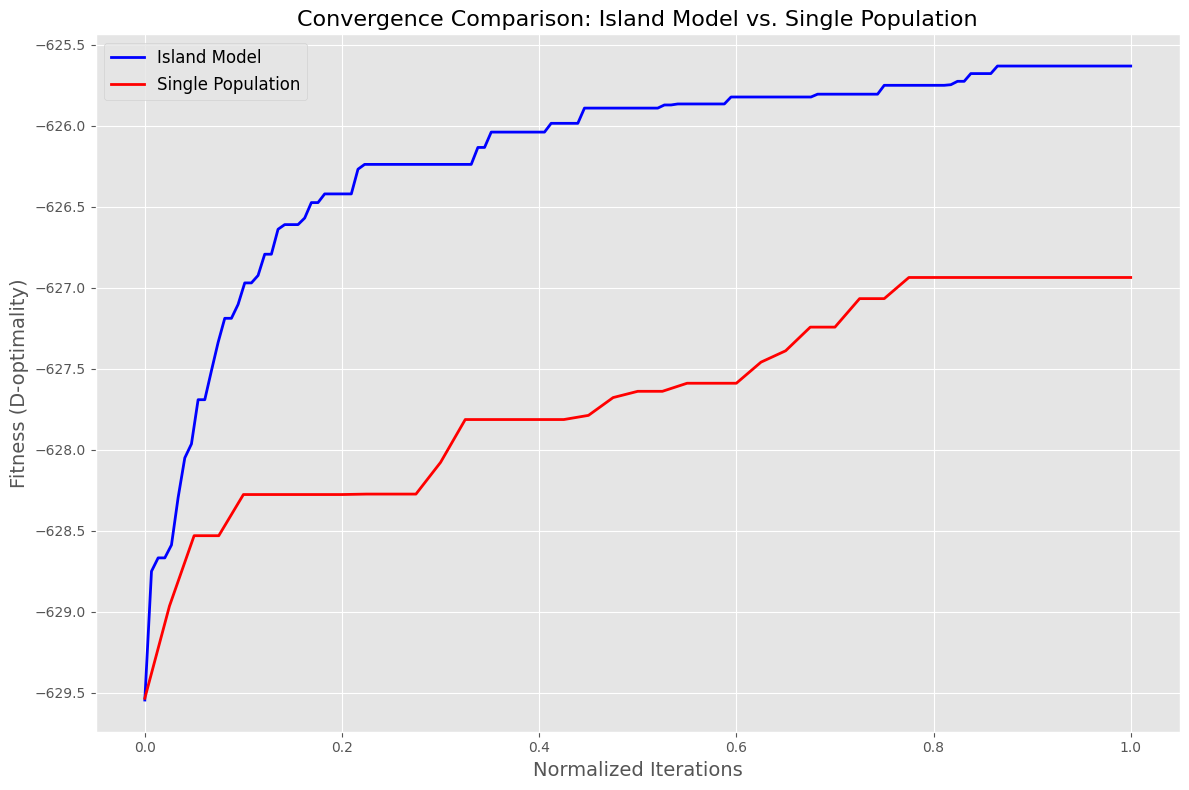

In [16]:
# Plot convergence history
plt.figure(figsize=(12, 8))

# Normalize iterations to common scale (0-1)
x_island = np.linspace(0, 1, len(result_island.fitness_history))
x_single = np.linspace(0, 1, len(result_single.fitness_history))

plt.plot(x_island, result_island.fitness_history, 'b-', label='Island Model', linewidth=2)
plt.plot(x_single, result_single.fitness_history, 'r-', label='Single Population', linewidth=2)

plt.title('Convergence Comparison: Island Model vs. Single Population', fontsize=16)
plt.xlabel('Normalized Iterations', fontsize=14)
plt.ylabel('Fitness (D-optimality)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Custom Optimization Functions

TrainSelPy is highly extensible, allowing you to define custom optimization criteria. Let's demonstrate how to create a custom optimization function that combines multiple criteria:

In [17]:
# Create a dataset for custom optimization
n_samples = 100
n_features = 30

np.random.seed(42)
# Create a marker matrix
M_custom = np.random.choice([-1, 0, 1], size=(n_samples, n_features), p=[0.25, 0.5, 0.25])

# Calculate distance matrix
from scipy.spatial.distance import pdist, squareform
dist_matrix = squareform(pdist(M_custom))

# Create a TrainSel data object
ts_data_custom = make_data(M=M_custom)
ts_data_custom["FeatureMat"] = M_custom
ts_data_custom["DistMat"] = pd.DataFrame(dist_matrix)

# Define a custom optimization function combining D-optimality and maximin criteria
def custom_composite_criterion(solution, data):
    """Custom criterion combining D-optimality and diversity."""
    # Calculate D-optimality
    dopt_value = dopt(solution, data)
    
    # Calculate maximin criterion (diversity)
    maximin_value = maximin_opt(solution, data)
    
    # Scale the objectives to make them comparable
    # We're aiming to maximize both
    scaled_dopt = dopt_value / 100  # Scale down D-optimality to match maximin range
    
    # Return weighted combination (can adjust weights to emphasize one objective more)
    return 0.7 * scaled_dopt + 0.3 * maximin_value

# Run the optimization with the custom criterion
result_custom = train_sel(
    data=ts_data_custom,
    candidates=[list(range(n_samples))],
    setsizes=[15],
    settypes=["UOS"],
    stat=custom_composite_criterion,
    control=set_control_default(),
    verbose=True
)

# Calculate individual criteria values for the solution
selected = result_custom.selected_indices[0]
dopt_val = dopt(selected, ts_data_custom)
maximin_val = maximin_opt(selected, ts_data_custom)

print(f"\nSelected {len(selected)} samples: {selected}")
print(f"Composite fitness: {result_custom.fitness:.6f}")
print(f"D-optimality: {dopt_val:.6f}")
print(f"Maximin diversity: {maximin_val:.6f}")

Starting TrainSelPy optimization
Starting GA with population size 1000
Initial best fitness: -0.7095027668396776
Generation 0: Best fitness = -0.7095027668396776
Generation 10: Best fitness = -0.6684099450792547
Generation 20: Best fitness = -0.6353673164665756
Generation 30: Best fitness = -0.610059734704161
Generation 40: Best fitness = -0.6035132570055752
Generation 50: Best fitness = -0.5729948787628487
Generation 60: Best fitness = -0.5694534862278946
Generation 70: Best fitness = -0.5150610398523372
Generation 80: Best fitness = -0.5109630632564954
Generation 90: Best fitness = -0.5109630632564954
Generation 100: Best fitness = -0.5091743986394883
Generation 110: Best fitness = -0.5091743986394883
Generation 120: Best fitness = -0.48700151530893776
Generation 130: Best fitness = -0.48700151530893776
Generation 140: Best fitness = -0.48700151530893776
Generation 150: Best fitness = -0.4834954703125549
Generation 160: Best fitness = -0.4834954703125549
Generation 170: Best fitness 

### Compare Different Optimization Criteria


Running optimization with D-optimality criterion...
Starting GA with population size 1000
Initial best fitness: -306.4522336463026
Generation 0: Best fitness = -305.9096503922458
Generation 10: Best fitness = -304.0028614184749
Generation 20: Best fitness = -303.80819617436316
  Fitness: -303.324482

Running optimization with Maximin criterion...
Starting GA with population size 1000
Initial best fitness: 4.69041575982343
Generation 0: Best fitness = 4.69041575982343
Generation 10: Best fitness = 4.898979485566356
Generation 20: Best fitness = 4.898979485566356
  Fitness: 5.000000

Running optimization with Composite criterion...
Starting GA with population size 1000
Initial best fitness: -0.7428780840382028
Generation 0: Best fitness = -0.7428780840382028
Generation 10: Best fitness = -0.6688138541953037
Generation 20: Best fitness = -0.6049826746923468
  Fitness: -0.604983

Comparison of different criteria:


,Criterion,D-optimality,Maximin
0,D-optimality,-303.324482,5.291503
1,Maximin,-306.306163,5.000000
2,Composite,-304.955504,5.099020


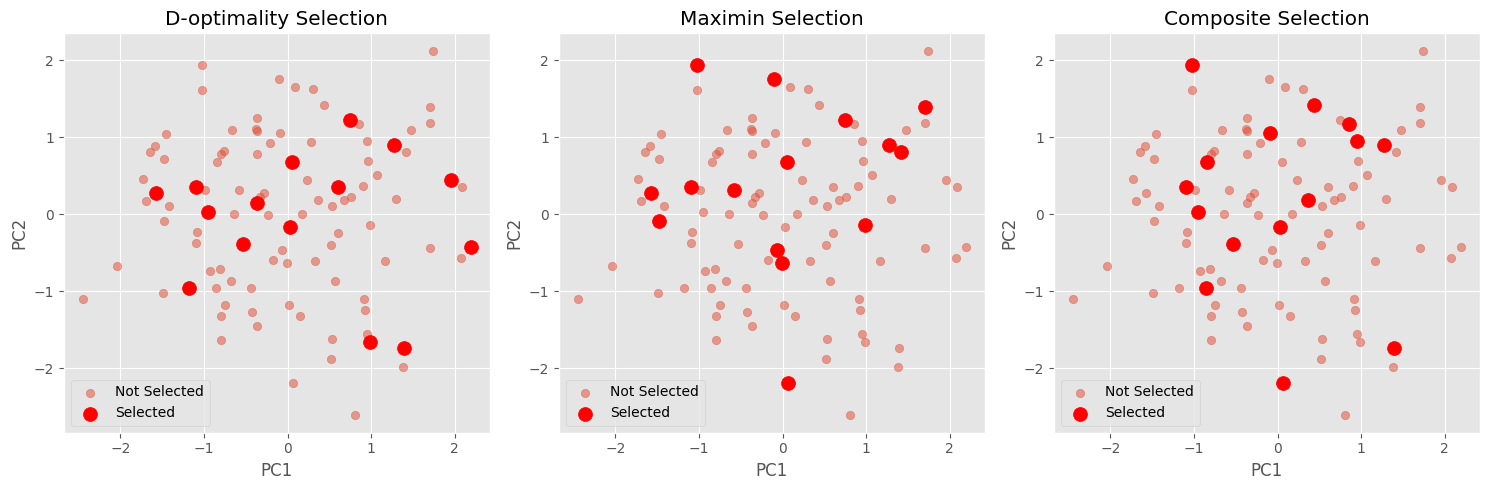

In [18]:
# Compare different criteria on the same dataset
criteria = [
    ("D-optimality", dopt),
    ("Maximin", maximin_opt),
    ("Composite", custom_composite_criterion)
]

results = {}

for name, criterion in criteria:
    print(f"\nRunning optimization with {name} criterion...")
    
    control = set_control_default()
    control["niterations"] = 30  # Reduced for demonstration
    
    result = train_sel(
        data=ts_data_custom,
        candidates=[list(range(n_samples))],
        setsizes=[15],
        settypes=["UOS"],
        stat=criterion,
        control=control,
        verbose=False
    )
    
    selected = result.selected_indices[0]
    results[name] = {
        "selected": selected,
        "fitness": result.fitness,
        "dopt": dopt(selected, ts_data_custom),
        "maximin": maximin_opt(selected, ts_data_custom)
    }
    
    print(f"  Fitness: {result.fitness:.6f}")

# Create a comparison table
comparison_df = pd.DataFrame({
    'Criterion': [name for name, _ in criteria],
    'D-optimality': [results[name]['dopt'] for name, _ in criteria],
    'Maximin': [results[name]['maximin'] for name, _ in criteria]
})

print("\nComparison of different criteria:")
display(comparison_df)

# Visualize the results using PCA
pca = PCA(n_components=2)
M_reduced = pca.fit_transform(M_custom)

plt.figure(figsize=(15, 5))

for i, (name, _) in enumerate(criteria):
    plt.subplot(1, 3, i+1)
    
    selected = results[name]['selected']
    selected_mask = np.zeros(n_samples, dtype=bool)
    selected_mask[selected] = True
    
    plt.scatter(M_reduced[~selected_mask, 0], M_reduced[~selected_mask, 1], alpha=0.5, label="Not Selected")
    plt.scatter(M_reduced[selected_mask, 0], M_reduced[selected_mask, 1], color="red", s=100, label="Selected")
    
    plt.title(f"{name} Selection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Advanced Initialization: Convex Relaxations

For large-scale problems ($N > 100$), starting with a random population might be inefficient. TrainSelPy offers **Convex Relaxations** (Continuous Approximations) to quickly find high-quality starting points. These methods relax the discrete constraints ($w_i \in \{0, 1\}$) to continuous ones ($0 \le w_i \le 1$), solve the easier continuous problem, and then discretize the result.

This approach is particularly effective for **CDMEAN** and **PEV** criteria, providing a jump-start to the Genetic Algorithm.

In [19]:
# Import Relaxation tools
import numpy as np
from trainselpy.relaxations import CDMeanOptimality, ConvexRelaxationSolver, discretize
from trainselpy import make_data, train_sel, set_control_default

# 1. Setup Data
# Ensure we have a relationship matrix K. If running this cell out of order, we generate a small one.
if 'K' not in locals():
    print("Generating demo data for relaxation...")
    n_samples_rel = 100
    M_rel = np.random.randn(n_samples_rel, 20)
    K_rel = np.dot(M_rel, M_rel.T) / 20
    K_rel += np.eye(n_samples_rel) * 1e-6
    N_rel = n_samples_rel
else:
    K_rel = K
    N_rel = K.shape[0]

# Standard TrainSel data object
data_rel = make_data(K=K_rel, lambda_val=1.0)

# 2. Run Convex Relaxation
print("Running Convex Relaxation (Frank-Wolfe)...")
criterion = CDMeanOptimality(K_rel, lambda_val=1.0)
solver = ConvexRelaxationSolver(criterion, method="FW")

# Solve for k items (e.g. 10)
k_target = 10
continuous_weights = solver.solve(X=None, k=k_target)

# 3. Discretize to get indices
starting_indices = discretize(continuous_weights, k=k_target, method='top_k')
print(f"Relaxation suggested indices: {starting_indices}")

# 4. Inject into TrainSel
init_sol_dict = {
    "solnIntMat": np.array([starting_indices])
}

# 5. Run GA with refined initialization
print("Starting GA with relaxation initialization...")
result_relaxed = train_sel(
    data=data_rel,
    candidates=[list(range(N_rel))],
    setsizes=[k_target],
    settypes=["UOS"],
    init_sol=init_sol_dict, 
    control=set_control_default(niterations=50, npop=100), # Reduced iterations thanks to good start
    verbose=True
)

print(f"Final Best Fitness: {result_relaxed.fitness:.6f}")

Running Convex Relaxation (Frank-Wolfe)...
Relaxation suggested indices: [4, 12, 27, 41, 44, 46, 60, 74, 77, 83]
Starting GA with relaxation initialization...
Starting TrainSelPy optimization
Starting GA with population size 100
Initial best fitness: 0.06863543125861386
Generation 0: Best fitness = 0.06863543125861386
Generation 10: Best fitness = 0.07508938366288741
Generation 20: Best fitness = 0.07646181889627533
Generation 30: Best fitness = 0.07695462584734727
Generation 40: Best fitness = 0.07724146603259971
Optimization completed in 2.04 seconds
Final fitness: 0.07724146603259971
Final Best Fitness: 0.077241


## Performance Optimization

TrainSelPy offers several ways to improve performance for large-scale problems:

In [20]:
# Demonstrate performance optimization strategies
print("TrainSelPy Performance Optimization Strategies:")
print("\n1. Island Model Parallelization")
print("   - Set nislands > 1 and parallelizable=True")
print("   - Example: control = train_sel_control(nislands=4, parallelizable=True, mc_cores=4)")
print("   - Use n_jobs parameter in train_sel() to specify the number of parallel jobs")

print("\n2. Adjust Genetic Algorithm Parameters")
print("   - Increase population size (npop) for better exploration")
print("   - Adjust crossover and mutation rates (crossprob, mutprob)")
print("   - Example: control = train_sel_control(npop=500, crossprob=0.8, mutprob=0.1)")

print("\n3. Use Dynamic Elite Size Adjustment")
print("   - Enables automatic adjustment of elite population")
print("   - Example: control = train_sel_control(dynamicNelite=True)")

print("\n4. Simulated Annealing Refinement")
print("   - Fine-tunes solutions after genetic algorithm")
print("   - Adjust parameters: niterSANN, tempini, tempfin")
print("   - Example: control = train_sel_control(niterSANN=100, tempini=100.0, tempfin=0.1)")

print("\n5. Time Estimation")
# Demonstrate time estimation

# Estimate time for different problem sizes
problem_sizes = [(100, 10), (500, 50), (1000, 100)]

print("\nEstimated optimization times:")
for n_ind, n_sel in problem_sizes:
    time_est = time_estimation(n_ind, n_sel, niter=100)
    print(f"  {n_ind} individuals, select {n_sel}: {time_est:.2f} seconds")

TrainSelPy Performance Optimization Strategies:

1. Island Model Parallelization
   - Set nislands > 1 and parallelizable=True
   - Example: control = train_sel_control(nislands=4, parallelizable=True, mc_cores=4)
   - Use n_jobs parameter in train_sel() to specify the number of parallel jobs

2. Adjust Genetic Algorithm Parameters
   - Increase population size (npop) for better exploration
   - Adjust crossover and mutation rates (crossprob, mutprob)
   - Example: control = train_sel_control(npop=500, crossprob=0.8, mutprob=0.1)

3. Use Dynamic Elite Size Adjustment
   - Enables automatic adjustment of elite population
   - Example: control = train_sel_control(dynamicNelite=True)

4. Simulated Annealing Refinement
   - Fine-tunes solutions after genetic algorithm
   - Adjust parameters: niterSANN, tempini, tempfin
   - Example: control = train_sel_control(niterSANN=100, tempini=100.0, tempfin=0.1)

5. Time Estimation

Estimated optimization times:
  100 individuals, select 10: 200.00 

## Real-world Applications

Let's summarize some real-world applications of TrainSelPy:

### 1. Genomic Selection

TrainSelPy is highly effective for optimizing training populations in genomic selection:

- Selecting individuals for phenotyping
- Balancing genetic gain and diversity
- Optimizing multi-environment trials
- Allocating resources across multiple traits

### 2. Experimental Design

TrainSelPy can optimize experimental designs:

- D-optimal designs
- Sequential experimentation
- Multi-stage designs
- Balanced incomplete block designs

### 3. Operations Research

TrainSelPy can solve various combinatorial optimization problems:

- Traveling salesman problem
- Knapsack problems
- Resource allocation
- Portfolio optimization

### 4. Machine Learning

TrainSelPy supports machine learning applications:

- Feature selection
- Active learning
- Training data subset selection
- Hyperparameter optimization

## Conclusion

This vignette has demonstrated the core features and applications of TrainSelPy:

1. **Selection Types**: UOS, OS, UOMS, OMS, BOOL, and DBL
2. **Optimization Criteria**: D-optimality, Maximin, PEV, CDMean, and custom functions
3. **Combinatorial Optimization**: Mixed integer problems with both discrete and continuous variables
4. **Balancing Multiple Objectives**: Handling competing objectives like gain and diversity
5. **Genomic Selection**: Training population optimization for breeding
6. **Performance Optimization**: Island model and parallel processing

TrainSelPy offers a flexible and powerful framework for solving a wide range of selection and optimization problems, with particular strengths in applications to breeding and genomic selection.